In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, auc, average_precision_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap

/Users/kiannahendricks/opt/anaconda3/envs/neuropath8/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/kiannahendricks/opt/anaconda3/envs/neuropath8/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

## Reading in data

In [3]:
data = pd.read_excel("data/final_features_selected.xlsx")
data

Overall AD neuropathological Change  Age at Death Cat  Sex  \
0                                     0                 2    1   
1                                     1                 2    0   
2                                     0                 4    1   
3                                     3                 3    0   
4                                     2                 4    1   
..                                  ...               ...  ...   
78                                    1                 4    1   
79                                    2                 3    1   
80                                    3                 4    1   
81                                    3                 4    0   
82                                    2                 4    0   

    Highest level of education  APOE4 Status  Overall CAA Score  Thal  Braak  \
0                            2             0                  0     0      3   
1                            2             0                  0     2      3   
2                            0             0                  0     0      3   
3                            1             1                  2     5      4   
4                            0             0                  2     3      3   
..                         ...           ...                ...   ...    ...   
78                           2             0                  0     4      1   
79                           1             0                  2     3      5   
80                           0             1                  2     4      5   
81                           3             0                  2     4      4   
82                           3             0                  0     2      4   

    total Iba1 positive area_Grey matter  Fresh Brain Weight Numeric  \
0                             2518983.00                        1035   
1                             5713633.00                        1338   
2                             5981221.00                        1078   
3                              574576.70                        1261   
4                              110198.17                        1003   
..                                   ...                         ...   
78                            1933152.00                        1082   
79                            2908875.00                        1168   
80                            4060723.00                         925   
81                            3356090.00                        1159   
82                            2527673.00                        1168   

    total Iba1 positive process length_Grey matter  ripa tTau_Grey matter  \
0                                       8220078.00            1122.432229   
1                                       2989425.00            7005.543158   
2                                       6866055.00             147.565263   
3                                       1085434.30             283.436842   
4                                         52887.63             258.624211   
..                                             ...                    ...   
78                                      1006315.30             704.801053   
79                                       740188.30             740.583158   
80                                       832638.90             894.136842   
81                                       677349.20             531.651579   
82                                       582392.10             611.000000   

    ABeta40 pg/ug (RIPA)  ABeta42 pg/ug (RIPA)  ripa abeta40_Grey matter  \
0               0.019621              0.971579                981.444000   
1               0.215789              2.744211                  0.007088   
2               0.000598              0.147158                 21.423158   
3              60.766316             80.266316                 25.295789   
4               5.136842             16.156842                  0.526168   
..  

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Overall AD neuropathological Change             83 non-null     int64  
 1   Age at Death Cat                                83 non-null     int64  
 2   Sex                                             83 non-null     int64  
 3   Highest level of education                      83 non-null     int64  
 4   APOE4 Status                                    83 non-null     int64  
 5   Overall CAA Score                               83 non-null     int64  
 6   Thal                                            83 non-null     int64  
 7   Braak                                           83 non-null     int64  
 8   total Iba1 positive area_Grey matter            83 non-null     float64
 9   Fresh Brain Weight Numeric                   

I need to remove Overal ADNC of 0 because it significies no AD.

In [5]:
data = data[data['Overall AD neuropathological Change'] != 0]
data['Overall AD neuropathological Change'].value_counts()
def transform_neuropathological_change(value):
    if value == 1 or value == 2:
        return 0
    if value == 3:
        return 1

In [6]:
data['binary_ADNC'] = data['Overall AD neuropathological Change'].map(transform_neuropathological_change)
data = data.drop('Overall AD neuropathological Change', axis=1)
data['binary_ADNC'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


binary_ADNC
1    41
0    33
Name: count, dtype: int64

## Preparing data for training

In [7]:
X = data.drop('binary_ADNC', axis=1)  
y = data['binary_ADNC']  

### Visualing the correlation between the final features

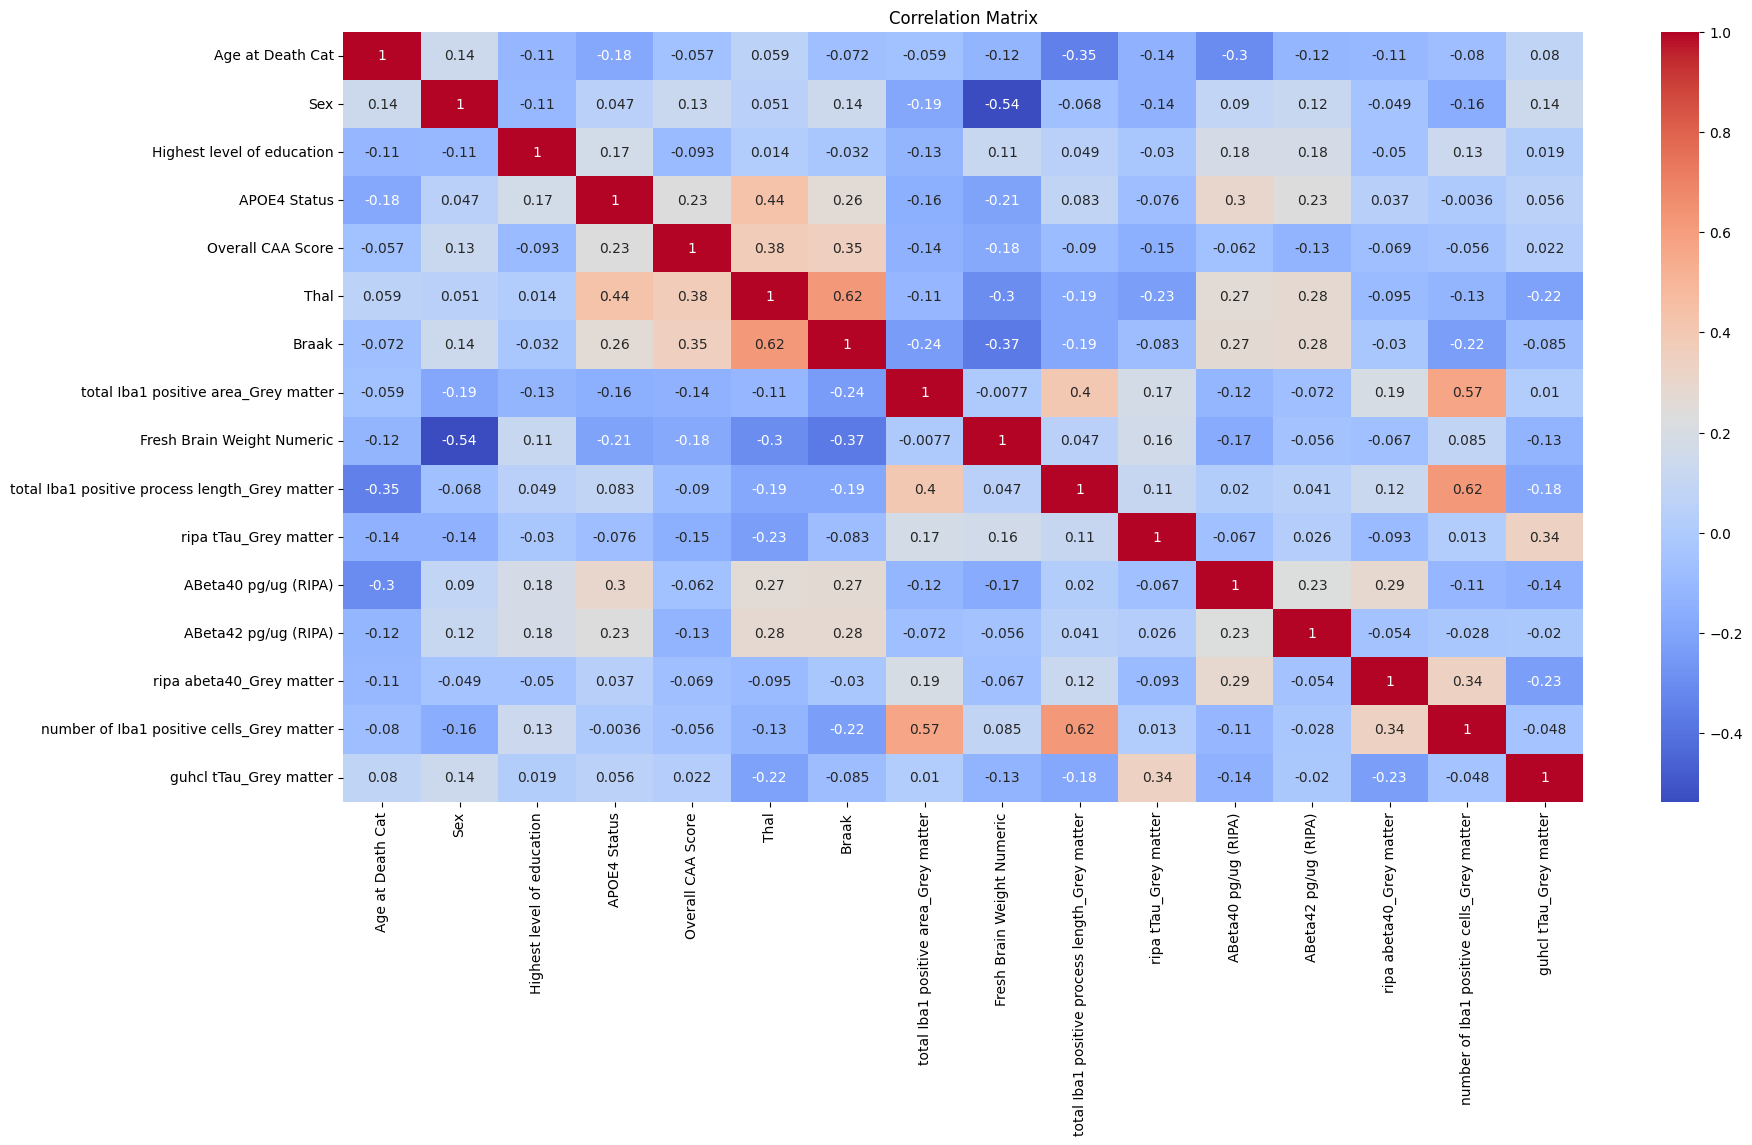

In [8]:
correlation_matrix = X.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.savefig('final_feature_data_heatmap.png')

### Scaling the features

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Splitting data for training, testing, and validating

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Training the models

Model: Logistic Regression
Validation ROC AUC: 0.8
Validation Precision: 0.7777777777777778
Validation Recall: 1.0
Validation F1-score: 0.8750000000000001
Test ROC AUC: 0.9375
Test Precision: 1.0
Test Recall: 0.875
Test F1-score: 0.9333333333333333
Confusion Matrix:
[[7 0]
 [1 7]]
Best Parameters: {'C': 1}
Cross-Validation Accuracy Scores: [0.66666667 0.66666667 0.5        0.5        0.        ]
Cross-Vaidation Mean Accuracy: 0.4666666666666666
Predictions: [1 0 0 1 1 1 0 1 0 0 1 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15




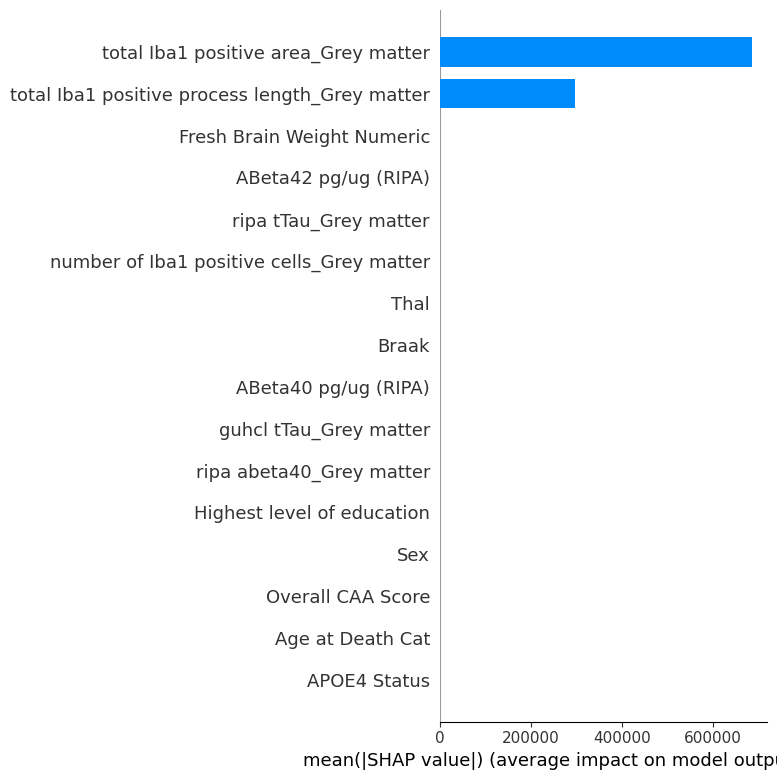

Model: Decision Tree
Validation ROC AUC: 0.9
Validation Precision: 0.875
Validation Recall: 1.0
Validation F1-score: 0.9333333333333333
Test ROC AUC: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Confusion Matrix:
[[7 0]
 [0 8]]
Best Parameters: {'max_depth': None}
Cross-Validation Accuracy Scores: [0.33333333 1.         0.5        0.         0.5       ]
Cross-Vaidation Mean Accuracy: 0.4666666666666666
Predictions: [1 0 0 1 1 1 0 1 0 1 1 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15




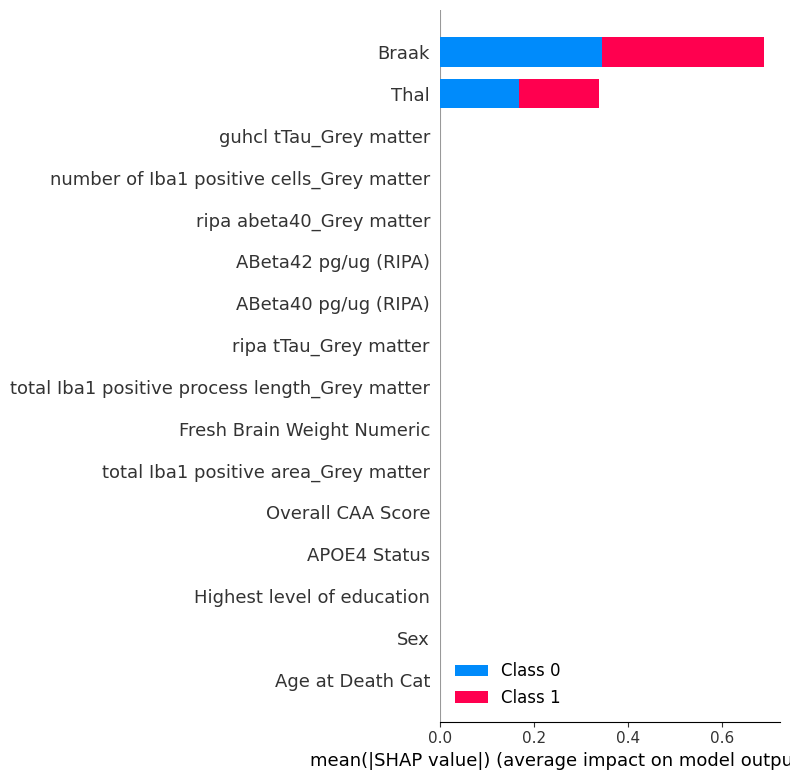

Model: Linear Discriminant Analysis
Validation ROC AUC: 0.8
Validation Precision: 0.7777777777777778
Validation Recall: 1.0
Validation F1-score: 0.8750000000000001
Test ROC AUC: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Confusion Matrix:
[[7 0]
 [0 8]]
Best Parameters: {}
Cross-Validation Accuracy Scores: [0.66666667 1.         0.5        1.         0.5       ]
Cross-Vaidation Mean Accuracy: 0.7333333333333333
Predictions: [1 0 0 1 1 1 0 1 0 1 1 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15




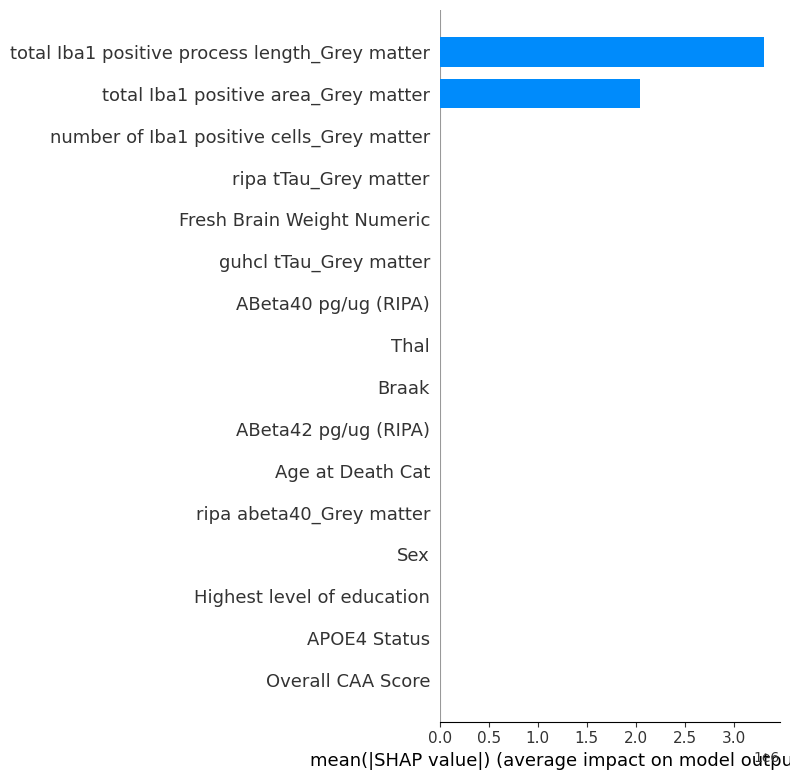

Model: Gaussian Naive Bayes
Validation ROC AUC: 0.9285714285714286
Validation Precision: 1.0
Validation Recall: 0.8571428571428571
Validation F1-score: 0.923076923076923
Test ROC AUC: 0.9375
Test Precision: 1.0
Test Recall: 0.875
Test F1-score: 0.9333333333333333
Confusion Matrix:
[[7 0]
 [1 7]]
Best Parameters: {}
Cross-Validation Accuracy Scores: [0.66666667 1.         0.5        0.         0.5       ]
Cross-Vaidation Mean Accuracy: 0.5333333333333333
Predictions: [1 0 0 1 1 1 0 1 0 1 0 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15




  0%|                                                    | 0/12 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

 58%|█████████████████████████▋                  | 7/12 [00:02<00:02,  2.38it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

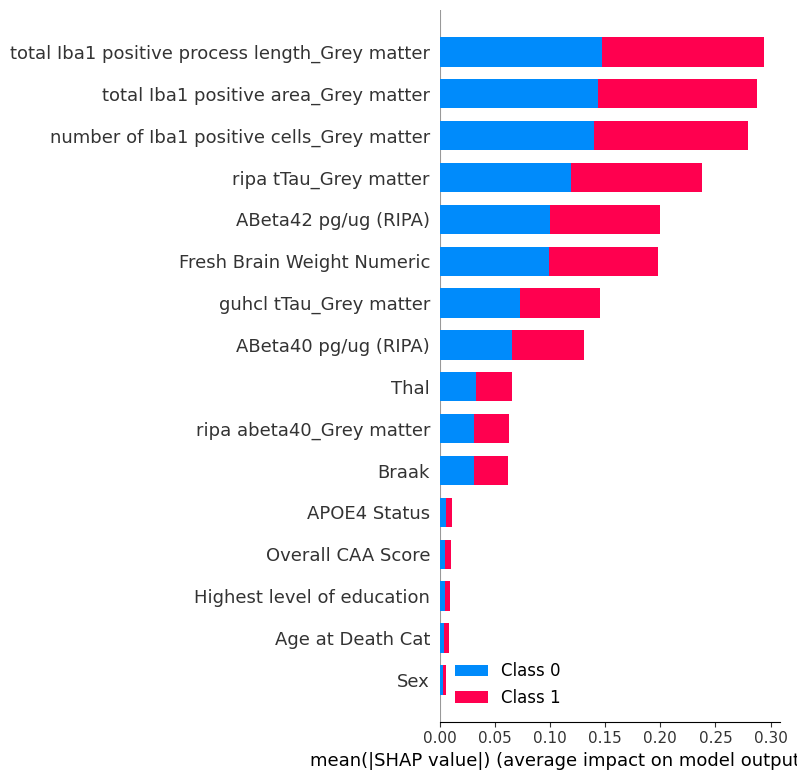

Model: Random Forest
Validation ROC AUC: 0.8
Validation Precision: 0.7777777777777778
Validation Recall: 1.0
Validation F1-score: 0.8750000000000001
Test ROC AUC: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Confusion Matrix:
[[7 0]
 [0 8]]
Best Parameters: {'n_estimators': 100}
Cross-Validation Accuracy Scores: [1.  1.  0.5 0.  0.5]
Cross-Vaidation Mean Accuracy: 0.6
Predictions: [1 0 0 1 1 1 0 1 0 1 1 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15




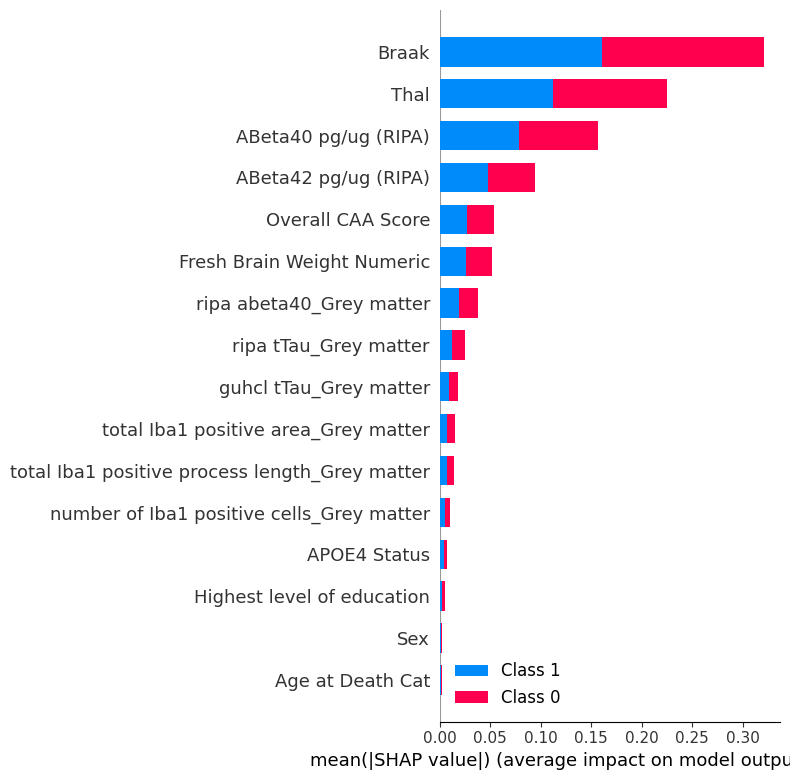

Model: Gradient Boosting
Validation ROC AUC: 0.9
Validation Precision: 0.875
Validation Recall: 1.0
Validation F1-score: 0.9333333333333333
Test ROC AUC: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Confusion Matrix:
[[7 0]
 [0 8]]
Best Parameters: {'learning_rate': 0.01}
Cross-Validation Accuracy Scores: [0.66666667 1.         0.5        0.         0.5       ]
Cross-Vaidation Mean Accuracy: 0.5333333333333333
Predictions: [1 0 0 1 1 1 0 1 0 1 1 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15




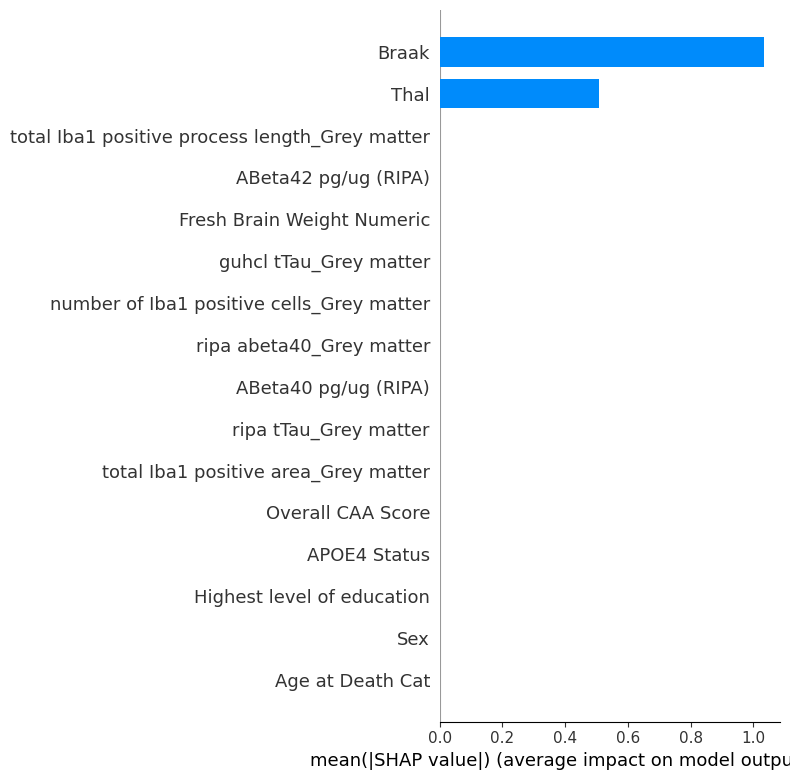

Model: XGBoost
Validation ROC AUC: 0.8
Validation Precision: 0.7777777777777778
Validation Recall: 1.0
Validation F1-score: 0.8750000000000001
Test ROC AUC: 0.8571428571428572
Test Precision: 0.8
Test Recall: 1.0
Test F1-score: 0.888888888888889
Confusion Matrix:
[[5 2]
 [0 8]]
Best Parameters: {'learning_rate': 0.01}
Cross-Validation Accuracy Scores: [0.66666667 0.66666667 0.5        0.         1.        ]
Cross-Vaidation Mean Accuracy: 0.5666666666666667
Predictions: [1 0 0 1 1 1 1 1 0 1 1 0 1 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.80      1.00      0.89         8

    accuracy                           0.87        15
   macro avg       0.90      0.86      0.86        15
weighted avg       0.89      0.87      0.86        15




ntree_limit is deprecated, use `iteration_range` or model slicing instead.


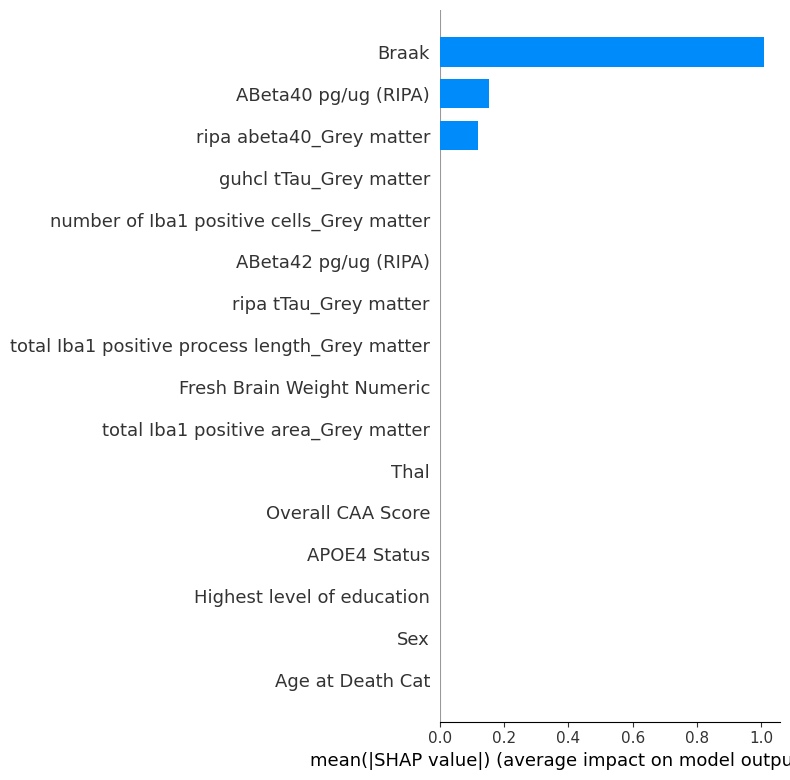

Model: Neural Network


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Validation ROC AUC: 0.9
Validation Precision: 0.875
Validation Recall: 1.0
Validation F1-score: 0.9333333333333333
Test ROC AUC: 0.9375
Test Precision: 1.0
Test Recall: 0.875
Test F1-score: 0.9333333333333333
Confusion Matrix:
[[7 0]
 [1 7]]
Best Parameters: {}
Cross-Validation Accuracy Scores: [1.         0.66666667 0.5        0.5        0.5       ]
Cross-Vaidation Mean Accuracy: 0.6333333333333333
Predictions: [1 0 0 1 1 1 0 1 0 0 1 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15




  0%|                                                    | 0/12 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

 58%|█████████████████████████▋                  | 7/12 [00:03<00:02,  2.20it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

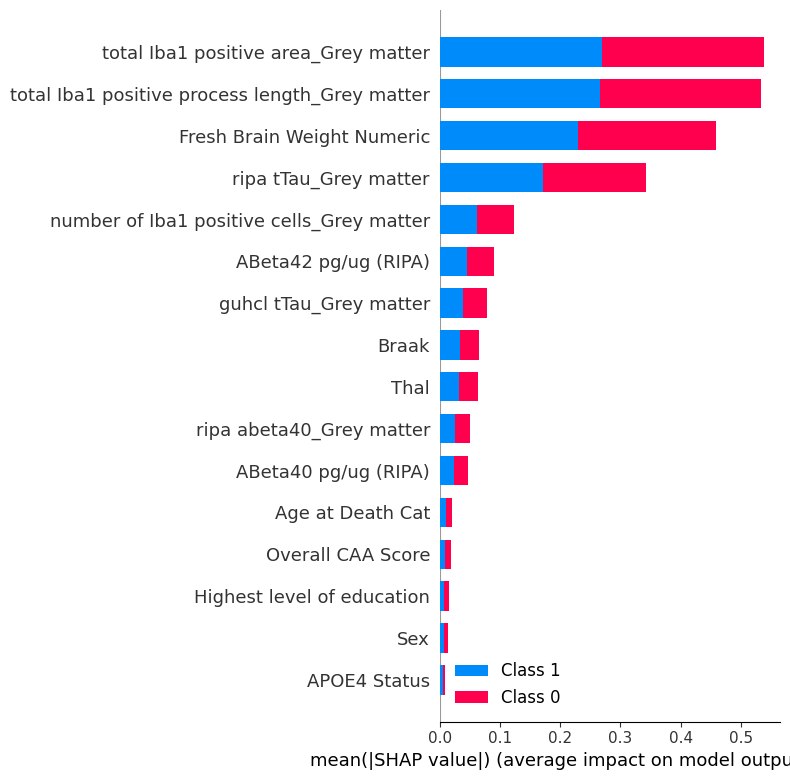

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "Neural Network": MLPClassifier()
}

params = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "Decision Tree": {"max_depth": [None, 5, 10]},
    "Linear Discriminant Analysis": {},
    "Gaussian Naive Bayes": {},
    "Random Forest": {"n_estimators": [100, 500, 1000]},
    "Gradient Boosting": {"learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"learning_rate": [0.01, 0.1, 0.2]},
    "Neural Network": {} 
}

results = []

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for name, model in models.items():
    print(f"Model: {name}")

    gs = GridSearchCV(estimator=model, param_grid=params[name], scoring=scoring, refit="accuracy", cv=cv)
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_
    best_params = gs.best_params_

    cv_scores = cross_val_score(best_model, X_val, y_val, cv=cv, scoring='accuracy')
    cv_mean_accuracy = cv_scores.mean()

    best_model.fit(X_train, y_train)

    y_val_pred = best_model.predict(X_val)

    val_roc_auc = roc_auc_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    print("Validation ROC AUC:", val_roc_auc)
    print("Validation Precision:", val_precision)
    print("Validation Recall:", val_recall)
    print("Validation F1-score:", val_f1)

    y_test_pred = best_model.predict(X_test)

    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print("Test ROC AUC:", test_roc_auc)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test F1-score:", test_f1)

    cm = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:")
    print(cm)
    
    result = {
        "Model": name,
        "Best Parameters": best_params,
        "Cross-Validation Accuracy Scores": cv_scores,
        "Cross-Validation Mean Accuracy": cv_mean_accuracy,
        "Predictions": y_test_pred
    }

    results.append(result)

    print("Best Parameters:", best_params)
    print("Cross-Validation Accuracy Scores:", cv_scores)
    print("Cross-Vaidation Mean Accuracy:", cv_mean_accuracy)
    print("Predictions:", y_test_pred)
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print()
    
    if isinstance(best_model, MLPClassifier) or isinstance(best_model, GaussianNB):
        explainer = shap.KernelExplainer(best_model.predict_proba, X)
        shap_values = explainer.shap_values(X_val, nsamples="auto")

    elif isinstance(best_model, (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, xgb.XGBClassifier)):
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_val)

    elif isinstance(best_model, (LogisticRegression, LinearDiscriminantAnalysis)):
        explainer = shap.LinearExplainer(best_model, X)
        shap_values = explainer.shap_values(X_val)

    else:
        raise ValueError(f"No SHAP explainer available for model type {type(best_model)}")

    shap.summary_plot(shap_values, X_val, plot_type='bar',feature_names=X.columns, max_display=len(X.columns))

## Neural Network

### Default Model

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.


Cross-Validation Scores:  [0.875      1.         1.         1.         0.875      0.71428571]
Mean Cross-Validation Score:  0.9107142857142857
Validation ROC AUC: 0.9
Validation Precision: 0.875
Validation Recall: 1.0
Validation F1-score: 0.9333333333333333
Validation Area under Precision-Recall Curve: 0.9375
Validation Average Precision Score: 0.875
Test ROC AUC: 0.875
Test Precision: 1.0
Test Recall: 0.75
Test F1-score: 0.8571428571428571
Confusion Matrix:
[[7 0]
 [2 6]]
Best Parameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'adam'}
Predictions: [0 0 0 1 1 1 0 1 0 0 1 0 0 1 0]



  0%|                                                    | 0/15 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

 47%|████████████████████▌                       | 7/15 [00:03<00:03,  2.11it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

 93%|████████████████████████████████████████▏  | 14/15 [00:06<00:00,  2.18it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

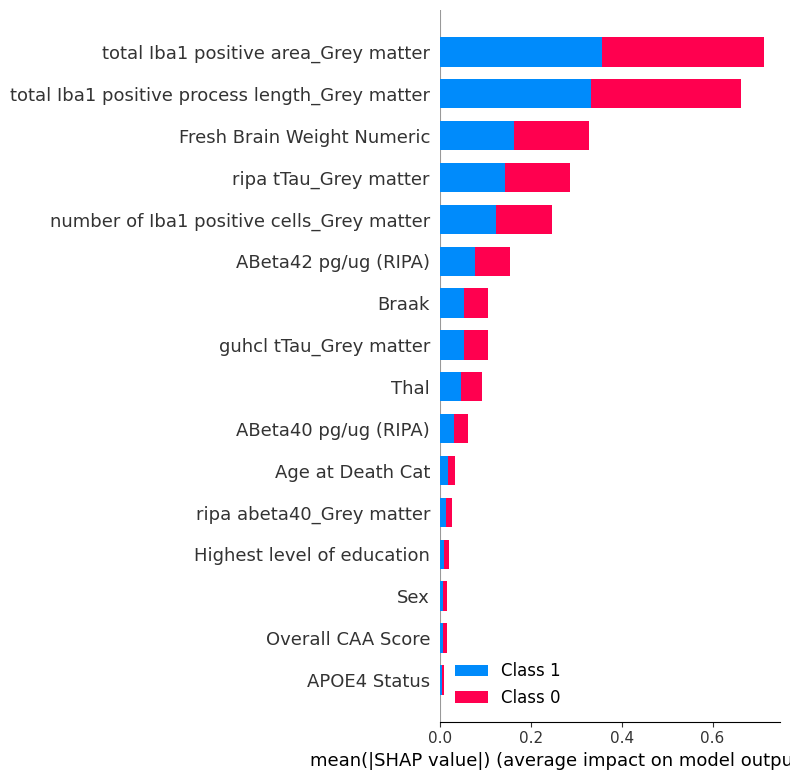

In [94]:
model = MLPClassifier()

model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)  
cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv)

print("Cross-Validation Scores: ", cv_scores)
mean_cv_accuracy = np.mean(cv_scores)
print("Mean Cross-Validation Score: ", mean_cv_accuracy)

y_val_pred = model.predict(X_val)

val_roc_auc = roc_auc_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Validation ROC AUC:", val_roc_auc)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1)

precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

pr_auc = auc(recall, precision)

avg_precision = average_precision_score(y_val, y_val_pred)

print("Validation Area under Precision-Recall Curve:", pr_auc)
print("Validation Average Precision Score:", avg_precision)

y_test_pred = model.predict(X_test)

test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Test ROC AUC:", test_roc_auc)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

result = {
    "Model": "Neural Network (default)",
    "Best Parameters": best_params,
    "Cross-Validation Accuracy Scores": cv_scores,
    "Cross-Validation Mean Accuracy": mean_cv_accuracy,
    "Predictions": y_test_pred
}
results.append(result)

print("Best Parameters:", result["Best Parameters"])
print("Predictions:", result["Predictions"])
print()

default_mlp_explainer = shap.KernelExplainer(model.predict_proba, X)
default_mlp_shap_values = default_mlp_explainer.shap_values(X_test, nsamples="auto")

shap.summary_plot(default_mlp_shap_values, X_test, plot_type='bar', feature_names=X.columns, max_display=len(X.columns))

### Performing grid search on neural network

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control th

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Precision is ill-def

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Precision is ill-def

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control t

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimize

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reach

Mean Cross-Validation Score:  0.5333333333333333
Validation ROC AUC: 0.8
Validation Precision: 0.7777777777777778
Validation Recall: 1.0
Validation F1-score: 0.8750000000000001
Test ROC AUC: 0.875
Test Precision: 1.0
Test Recall: 0.75
Test F1-score: 0.8571428571428571
Confusion Matrix:
[[7 0]
 [2 6]]
Best Parameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'adam'}
Cross-Validation Accuracy Scores: [1.         0.66666667 0.5        0.5        0.        ]
Cross-Validation Mean Accuracy: 0.5333333333333333
Predictions: [1 0 0 1 1 1 0 1 0 0 0 0 0 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.75      0.86         8

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15




  0%|                                                    | 0/15 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

 47%|████████████████████▌                       | 7/15 [00:03<00:03,  2.27it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

 93%|████████████████████████████████████████▏  | 14/15 [00:06<00:00,  2.27it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

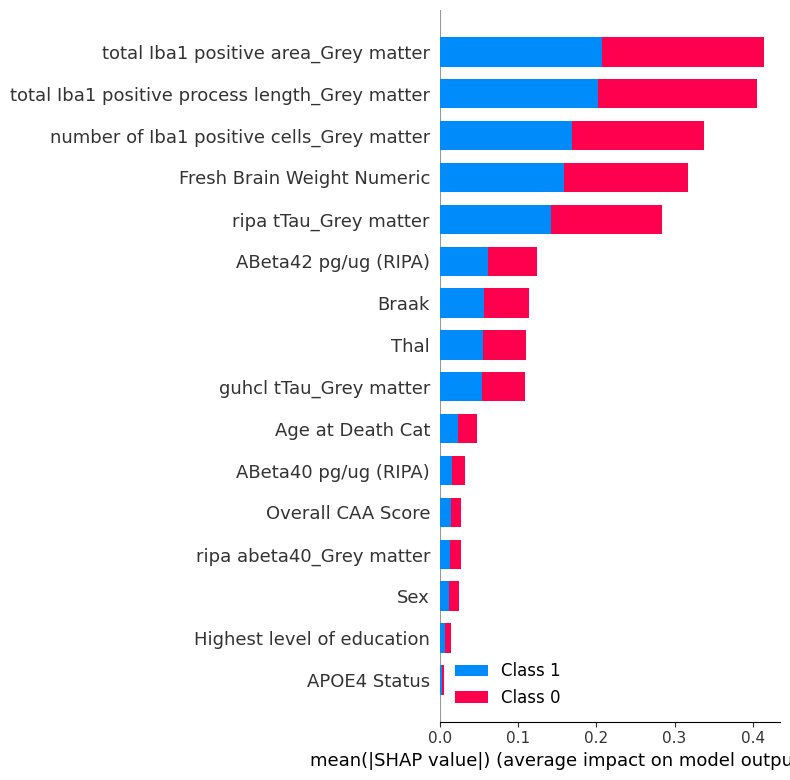

In [76]:
model = MLPClassifier()

params = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30)],
    'activation': ['tanh', 'relu', 'logistic'], 
    'solver': ['sgd', 'adam'], 
    'alpha': [0.0001, 0.01, 0.05],  
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'max_iter': [200, 300, 400]  
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

gs = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, refit="accuracy", cv=cv)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_
best_params = gs.best_params_

cv_scores = cross_val_score(best_model, X_val, y_val, cv=cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)
print("Mean Cross-Validation Score: ", mean_cv_accuracy)

best_model.fit(X_train, y_train)

y_val_pred = best_model.predict(X_val)

val_roc_auc = roc_auc_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Validation ROC AUC:", val_roc_auc)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1)

y_test_pred = best_model.predict(X_test)

test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Test ROC AUC:", test_roc_auc)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

result = {
    "Model": "Neural Network (grid search)",
    "Best Parameters": best_params,
    "Cross-Validation Accuracy Scores": cv_scores,
    "Cross-Validation Mean Accuracy": mean_cv_accuracy,
    "Predictions": y_test_pred
}

results.append(result)

print("Best Parameters:", best_params)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Cross-Validation Mean Accuracy:", mean_cv_accuracy)
print("Predictions:", y_test_pred)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print()

grid_mlp_explainer = shap.KernelExplainer(best_model.predict_proba, X)
grid_mlp_shap_values = grid_mlp_explainer.shap_values(X_test)

shap.summary_plot(grid_mlp_shap_values, X_test, plot_type='bar', feature_names=X.columns, max_display=len(X.columns))

## Final Neural Network

In [16]:
from sklearn.model_selection import StratifiedKFold

final_model = MLPClassifier(learning_rate = 'invscaling',
                     alpha = 0.1,
                     max_iter = 300,
                     activation = 'relu',
                     random_state=42
                     )

final_model.fit(X_train, y_train)

final_model_explainer = shap.KernelExplainer(final_model.predict_proba, X)
final_model_shap_values = final_model_explainer.shap_values(X_test, nsamples="auto")


Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  0%|                                                    | 0/15 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reprod

 47%|████████████████████▌                       | 7/15 [00:03<00:03,  2.14it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

 93%|████████████████████████████████████████▏  | 14/15 [00:06<00:00,  2.24it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Stan

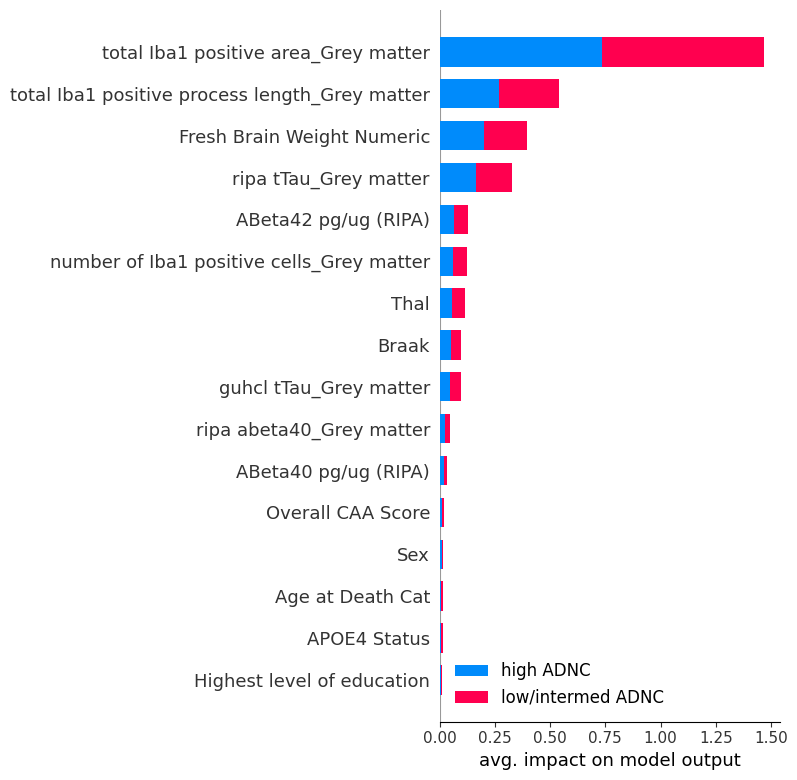

In [17]:
class_names = ['low/intermed ADNC', 'high ADNC']

shap.summary_plot(final_model_shap_values, X_test, plot_type='bar', feature_names=X.columns, class_names=class_names, max_display=len(X.columns), show=False)

plt.xlabel("avg. impact on model output")
plt.savefig('figures/final_model_shap_bar.pdf')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


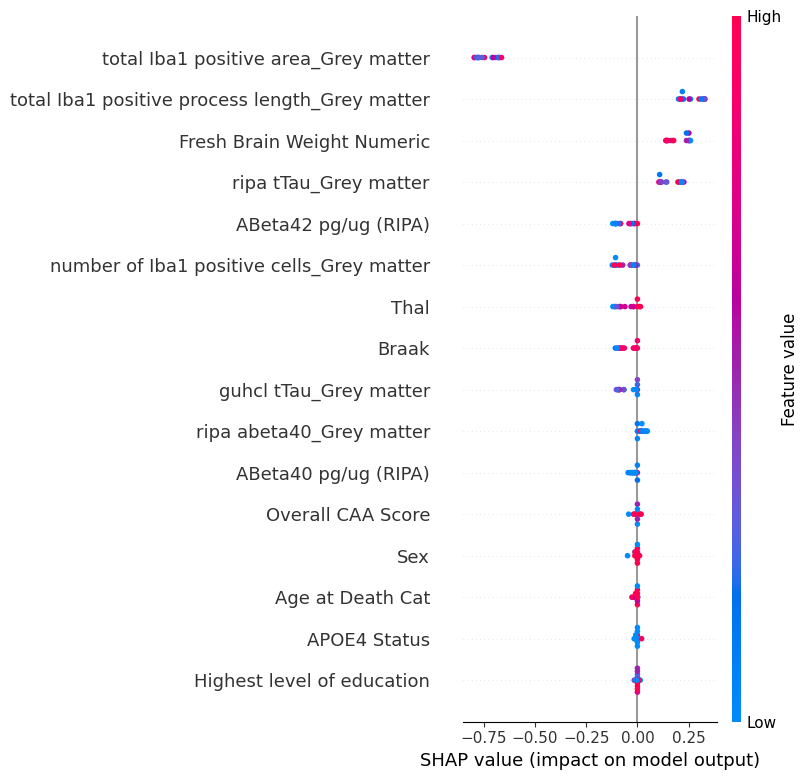

In [18]:
shap.summary_plot(final_model_shap_values[1], X_test, feature_names=X.columns, max_display=len(X.columns), show=False)
plt.savefig('figures/final_model_shap_severe_dot.pdf')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


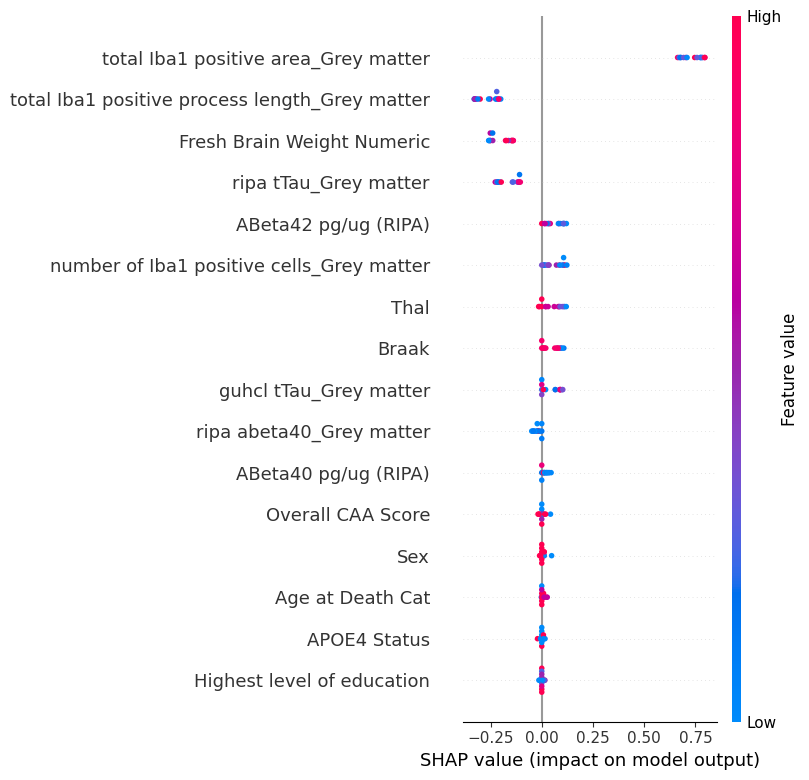

In [19]:
shap.summary_plot(final_model_shap_values[0], X_test, feature_names=X.columns, max_display=len(X.columns), show=False)
plt.savefig('figures/final_model_shap_non_severe_dot.pdf')

In [91]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(training_data = X_train, 
                                              mode = 'classification',
                                              feature_names = feature_names,
                                              class_names = ['low/intermed ADNC', 'high ADNC'],
                                              random_state = 42)

instance = X_test[11]

exp = explainer.explain_instance(instance, final_model.predict_proba, num_features=len(feature_names))

exp.show_in_notebook(show_table=True)
exp.save_to_file('figures/final_model_non_severe_lime_output.html')

In [92]:
instance_index = 11

observation = X_test[[instance_index]]

observation_df = pd.DataFrame(observation, columns=feature_names)

observation_df['binary_ADNC'] = y_test.iloc[instance_index]

print(observation_df)

   Age at Death Cat       Sex  Highest level of education  APOE4 Status  \
0          0.741246  0.802773                   -0.692907     -0.714286   

   Overall CAA Score      Thal     Braak  \
0           0.839259  0.231807 -0.578662   

   total Iba1 positive area_Grey matter  Fresh Brain Weight Numeric  \
0                             -0.312209                    0.758037   

   total Iba1 positive process length_Grey matter  ripa tTau_Grey matter  \
0                                       -0.858879              -0.251445   

   ABeta40 pg/ug (RIPA)  ABeta42 pg/ug (RIPA)  ripa abeta40_Grey matter  \
0             -0.270349             -0.311297                 -0.339124   

   number of Iba1 positive cells_Grey matter  guhcl tTau_Grey matter  \
0                                  -0.913669               -0.354811   

   binary_ADNC  
0            0  


In [93]:
import lime
from lime import lime_tabular

# Create a Lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data = X_train, 
                                              mode = 'classification',
                                              feature_names = feature_names,
                                              class_names = ['low/intermed ADNC', 'high ADNC'],
                                              random_state = 42)

instance = X_test[4]

exp = explainer.explain_instance(instance, final_model.predict_proba, num_features=len(feature_names))

exp.show_in_notebook(show_table=True)
exp.save_to_file('figures/final_model_severe_lime_output.html')

In [73]:
instance_index = 4

observation = X_test[[instance_index]]

observation_df = pd.DataFrame(observation, columns=feature_names)

observation_df['binary_ADNC'] = y_test.iloc[instance_index]

print(observation_df)


   Age at Death Cat       Sex  Highest level of education  APOE4 Status  \
0          0.741246  0.802773                   -0.026996           1.4   

   Overall CAA Score      Thal     Braak  \
0           0.839259  1.089494  0.332423   

   total Iba1 positive area_Grey matter  Fresh Brain Weight Numeric  \
0                             -0.412996                     0.01586   

   total Iba1 positive process length_Grey matter  ripa tTau_Grey matter  \
0                                       -0.090205              -0.369002   

   ABeta40 pg/ug (RIPA)  ABeta42 pg/ug (RIPA)  ripa abeta40_Grey matter  \
0              -0.19246             -0.078313                 -0.501447   

   number of Iba1 positive cells_Grey matter  guhcl tTau_Grey matter  \
0                                   0.834868                0.731002   

   binary_ADNC  
0            1  


In [85]:
results_data = pd.DataFrame(results)
results_data.to_excel('data/model_metrics_results.xlsx', index=False)